# TP5 : Auto Encodeurs

## Human In The Loop
 - On a besoin de beaucoup de Labels pour entrainer des modèles
 - Ca coute du temps humain, travail répétitif et peu gratifiant, ça coute cher et ça crée des dérives
 - [Your Roomba is watching you](https://www.technologyreview.com/2022/12/19/1065306/roomba-irobot-robot-vacuums-artificial-intelligence-training-data-privacy/)

## Auto Encodeurs
 - Une idée pour contrer le problème de labelisation des images : Les autoencodeurs 
 - Application : Implémenter un autoencoder pour encoder des courbes et étudier les atouts de ces architectures. 

# Autoencoders

 - Principe : C'est un réseau de neurones profond auquel on fournit $X$ en entrée et qui sort $X$ en sortie
 - ...
 - $X = Id X$ ?
 - L'intéret arrive quand on applique certaines contraintes à notre réseau.
 - Les applications sont alors multiples :
     - Compression
     - Extractions d'embeddings (comme en NLP)
     - Debruitage
     - Détection d'anomalie
     - Génération d'image   
 - L'architecture classique que l'on obtient est la suivante :
     - Un Encodeur
     - La représentation latente $Z$ (plus petite que l'entrée $X$)
     - Un décodeur

![](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png)
      
 - C'est une approche non supervisée car on compare la sortie à l'entrée et on veut qu'elles soient identiques
    - Pas besoin de label
    - Scalable!
    - On peut utiliser des techniques de Data Augmentation si on a peu de données et/ou si on souhaite obtenir des propriétés spécifiques
 

### Encodage de courbes



In [378]:
import numpy as np
from random import random as rand
from sklearn.model_selection import train_test_split as ttSplit
import matplotlib.pyplot as plt

import torch
from torch import nn

loss = nn.MSELoss()

%matplotlib inline

In [379]:
vecSize = 10
discretization = np.linspace(-1, 1, num=vecSize)

def genAffineCurve(interval):
  a = rand() - 0.5
  # f(x) = ax
  affineCurve = torch.Tensor([a * x for x in interval])
  return {"curve": affineCurve, "parameters": a}

In [380]:
def genDataset(discretization, generator, sampleSize=1000):
  data = [genAffineCurve(discretization) for i in range(sampleSize)]

  return ttSplit(data, test_size=0.2, random_state=1)

In [381]:
data_train, data_valid = genDataset(discretization, genAffineCurve, 1000)
len(data_train)

800

In [382]:
def plotCurve(interval, curve, a=None, legend=False):
    plt.figure(figsize=(10, 6))
    if isinstance(curve, list):
        curve = np.array(curve).T
    plt.plot(interval, curve, marker="o", label=a)
    if (legend):
        plt.legend()
    plt.show()

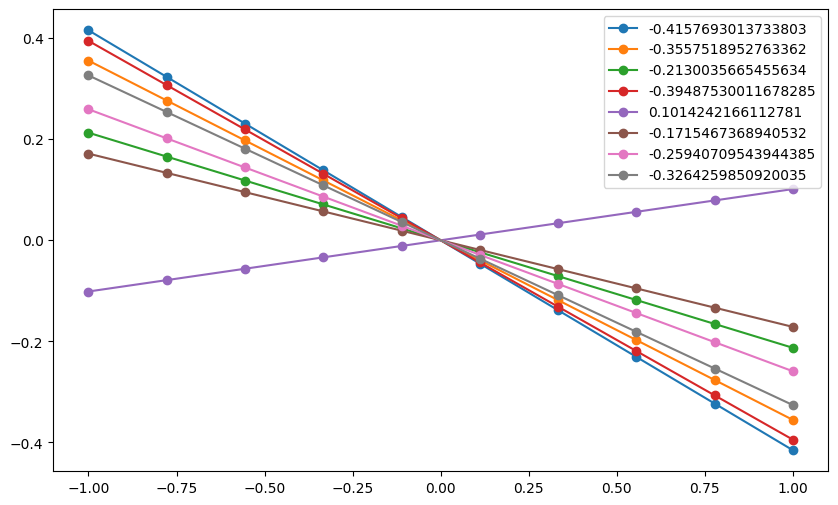

In [383]:
nbCurves = 8
plotCurve(discretization,
          [list(d["curve"]) for d in data_train[:nbCurves]],
          [d["parameters"] for d in data_train[:nbCurves]],
          True)


In [384]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

On va créer un auto encodeur qui aurra comme code un vecteur de dimension 1

Créez 2 réseaux:
 - Encoder : 
    - Les données en entrée seront de dimension *vector_size*
    - La donnée en sortie sera de dimension 1 
 - Decoder
    - Les données en entrée seront de dimension 1
    - La donnée en sortie sera de dimension *vector_size* 
    
Prennez l'architecture la plus simple possible dans ce 1 er cas

In [385]:
class Encoder(nn.Module):
  def __init__(self, vecSize):
    super().__init__()
    self.encoder = nn.Linear(vecSize, 1)
    # self.encoder = nn.Linear(vecSize, 1, True)
  def forward(self, x):
    return self.encoder(x)

class Decoder(nn.Module):
  def __init__(self, vecSize):
    super().__init__()
    self.decoder = nn.Linear(1, vecSize)
    # self.decoder = nn.Linear(1, vecSize, True)
  def forward(self, x):
    return self.decoder(x)

Entrainement du réseau !

Tracez la courbe d'erreur au cours de l'entrainement

In [386]:
from math import log2

def train(modelEncoder, modelDecoder, data_train, testCurve=None, epochs=10000, log=False):
  loss = nn.MSELoss()
  parameters = list(modelEncoder.parameters()) + list(modelDecoder.parameters())
  # optimizer = torch.optim.Adam(parameters, lr=0.01)
  optimizer = torch.optim.SGD(parameters, lr=0.01)

  errorsEpochs = []
  for epoch in range(epochs):
    epochLoss = 0
    for data in data_train:
      optimizer.zero_grad() # stop le gradient

      aPred = modelEncoder(data["curve"]) # forward-pass
      curvePred = modelDecoder(aPred) # forward-pass

      # lossVal = loss(curvePred, data["curve"])
      lossVal = loss(curvePred, data["curve"]) + \
        loss(aPred.reshape(-1), torch.Tensor([data["parameters"]]).reshape(-1))
        # loss(aPred, torch.Tensor([data["parameters"]]))

      lossVal.backward() # calcule gradient
      epochLoss += float(lossVal)

      optimizer.step() # update W + b
    errorsEpochs.append(0.5 * epochLoss)

    # print progress
    if (log and int(log2(epoch+1)) == log2(epoch+1)) or (epoch % 20 == 0):
      print(epoch, 0.5 * epochLoss)
      if testCurve != None:
        with torch.no_grad():
          aPred = modelEncoder(testCurve["curve"])
          curvePred = modelDecoder(aPred)
          plotCurve(discretization,
                    [list(testCurve["curve"]), list(curvePred)],
                    [testCurve["parameters"], float(aPred)],
                    True)

  return errorsEpochs

In [387]:
encoderModel = Encoder(vecSize)
decoderModel = Decoder(vecSize)

0 74.07318846834823


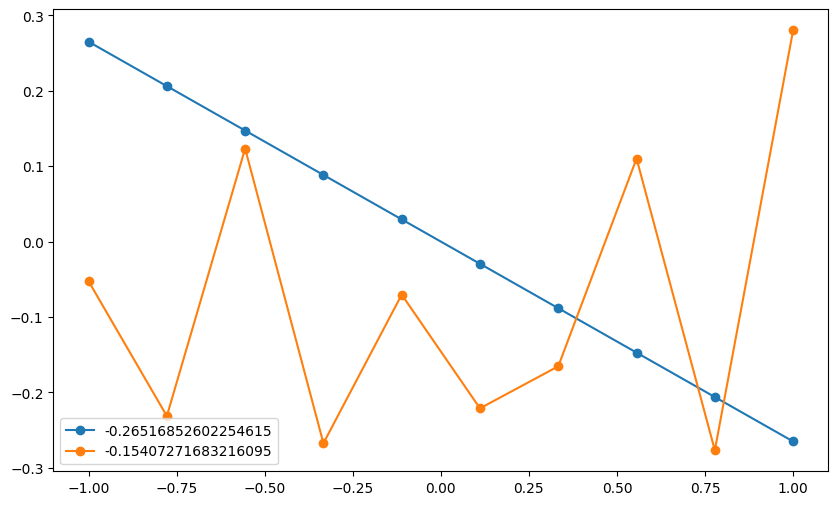

20 0.19456479582547703


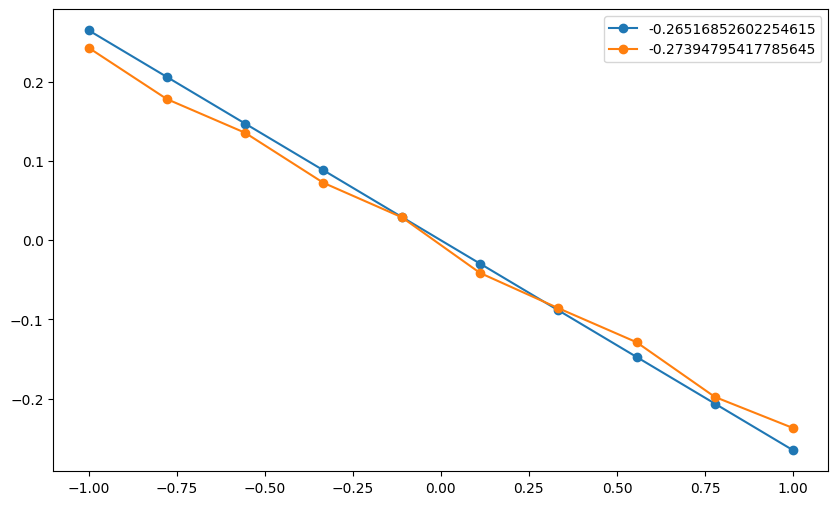

40 0.0033613745148191737


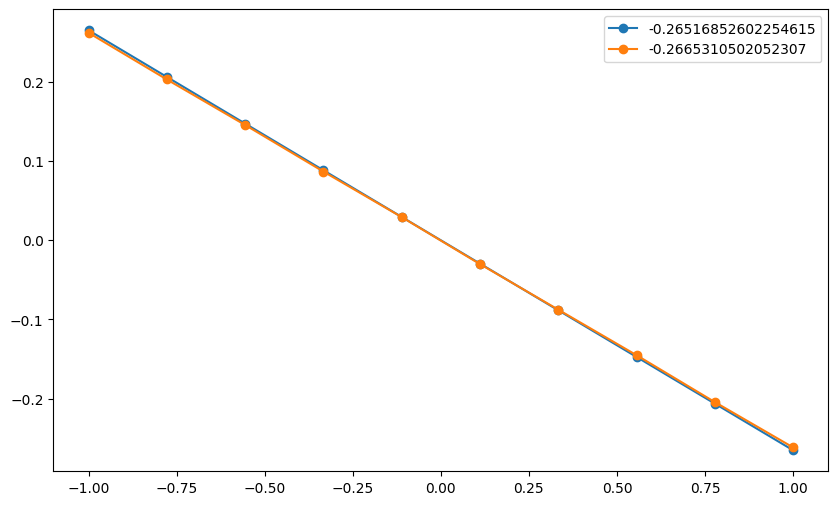

60 7.924006417903595e-05


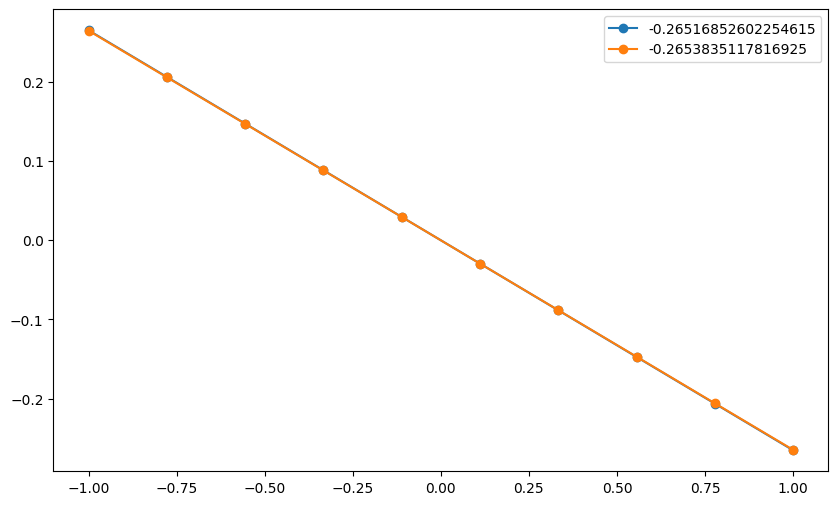

80 2.11521759912064e-06


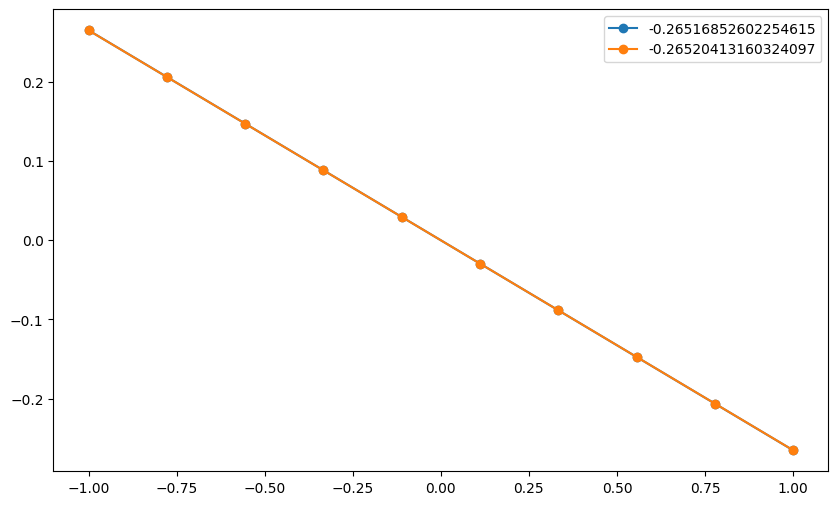

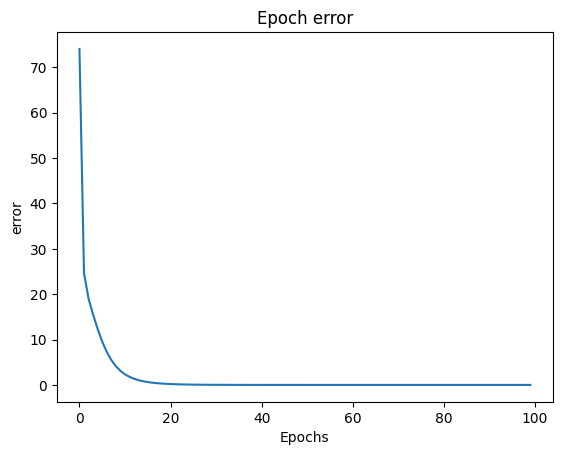

In [388]:
epochs = 100 #10000

testCurve = genAffineCurve(discretization)
errorsEpochs = train(encoderModel, decoderModel, data_train, testCurve, epochs)

plt.plot(range(epochs), errorsEpochs)
plt.title("Epoch error")
plt.xlabel("Epochs")
plt.ylabel("error")
plt.show()

Affichez sur un graphe l'input X et sa reconstruction par l'autoencodeur

In [389]:
sample = genAffineCurve(discretization)
curve = sample["curve"]
a = sample["parameters"]
with torch.no_grad():
  z = encoderModel(curve)
(a, z)

(0.3406567610563441, tensor([0.3407]))

Obtient-on $z = a$ ? 
- Si oui : Pourquoi ?
- Si non : Comment inclure cette contrainte ?

On recommence en incluant la contrainte $z = a$

In [390]:
def gen_affine_bias_curve(discretization):
  a = 10 * (rand() - 0.5)
  b = 10 * (rand() - 0.5)
  return {"curve": torch.Tensor([a*x+b for x in discretization]), "parameters": [a,b]}

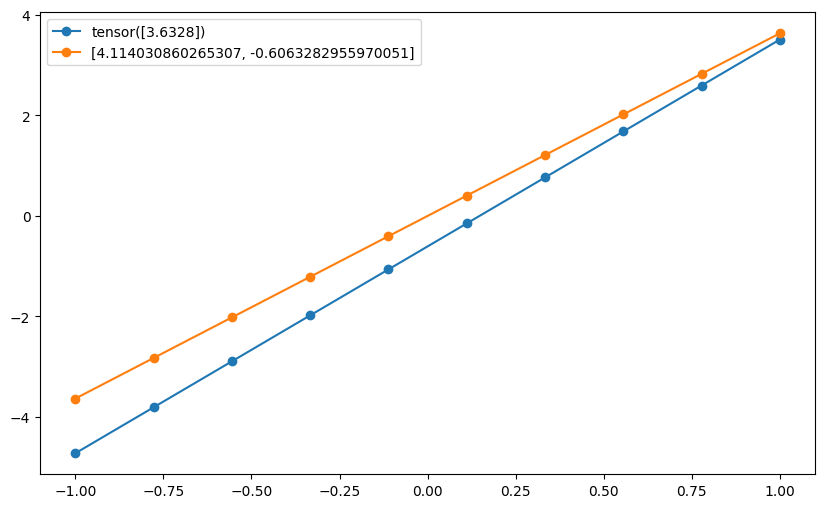

error=tensor(0.4621), (a=4.114030860265307, z=tensor([3.6328])), b=-0.6063282955970051


In [391]:
sample = gen_affine_bias_curve(discretization)
curve = sample["curve"]
a, b = sample["parameters"]
with torch.no_grad():
  z = encoderModel(curve)
  new_curve = decoderModel(z)
  error = loss(curve, new_curve)
plotCurve(discretization, [list(curve), list(new_curve)], [z, [a, b]], True)
print(f"{error=}, ({a=}, {z=}), {b=}")


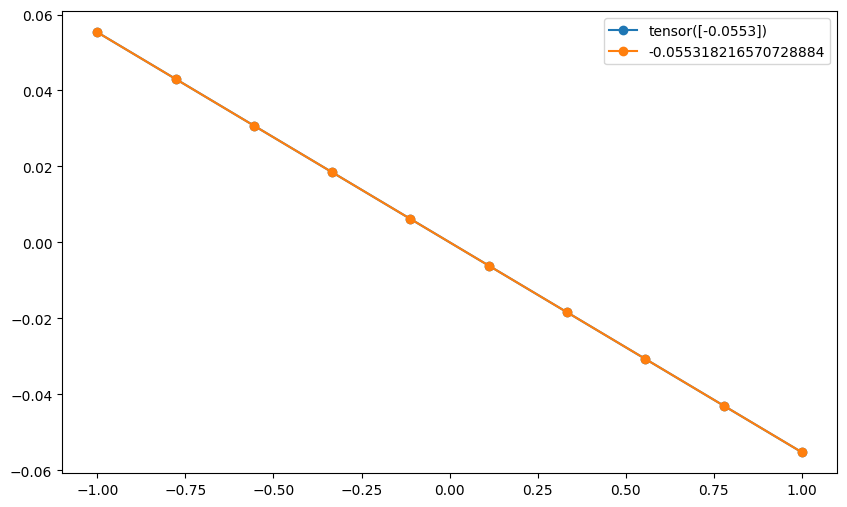

error=tensor(9.4437e-12), (a=-0.055318216570728884, z=tensor([-0.0553]))


In [392]:
sample = genAffineCurve(discretization)
curve = sample["curve"]
a = sample["parameters"]
with torch.no_grad():
  z = encoderModel(curve)
  new_curve = decoderModel(z)
  error = loss(curve, new_curve)
plotCurve(discretization, [list(curve), list(new_curve)], [z, a], True)
print(f"{error=}, ({a=}, {z=})")


Maintenant que se passe-t-il quand on présente au réseau une discrétisation d'une fonction du type $$ g(x) = \sin(b \pi x) $$

Codez la fonction gen_g, qui prend en paramètre la taille de la discrétisation, sample un b random et retourne le vecteur G associé à la discrétisation de $g(x)$.

In [393]:
from math import pi, sin

def gen_sinus_curve(discretization):
    b = 1 + 9 * rand()
    return {"curve": torch.Tensor([sin(b*pi*x) for x in discretization]), "parameters": b}

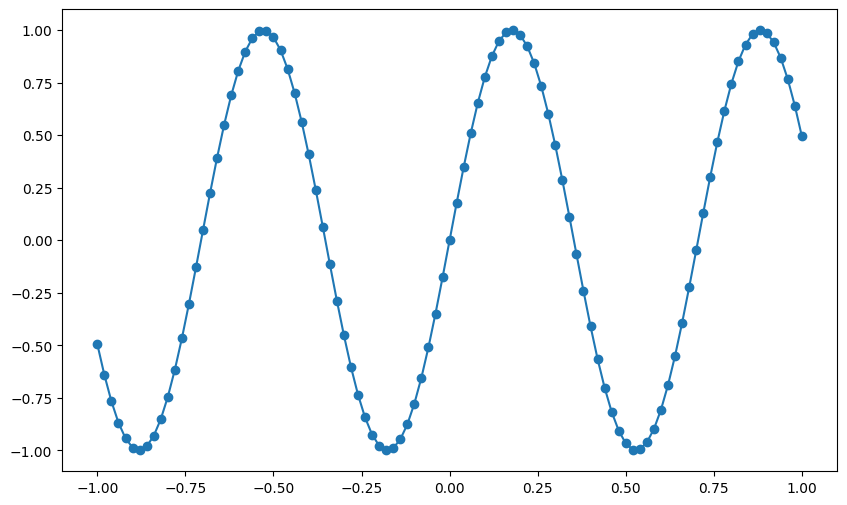

In [394]:
vecSize = 101
discretization = np.linspace(-1, 1, num=vecSize)

sample = gen_sinus_curve(discretization)
plotCurve(discretization, sample["curve"])

In [395]:
class EncoderSinus(nn.Module):
  def __init__(self, vector_size):
    super().__init__()
    self.encoder = nn.Linear(vector_size, 1)

  def forward(self, x):
    return self.encoder(x)


class DecoderSinus(nn.Module):
  def __init__(self, vector_size):
    super().__init__()
    self.decoder = nn.Linear(1, vector_size)

  def forward(self, x):
    return self.decoder(x)

In [396]:
data_train, data_valid = genDataset(discretization, gen_sinus_curve, 1000)
len(data_train)

800

In [397]:
encoderModel = EncoderSinus(vecSize)
decoderModel = DecoderSinus(vecSize)

0 142.1763132661581


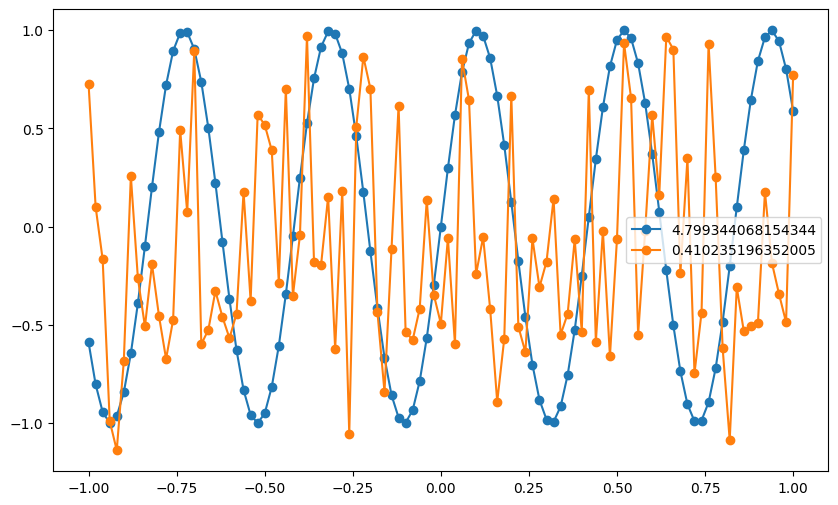

1 107.65196035802364


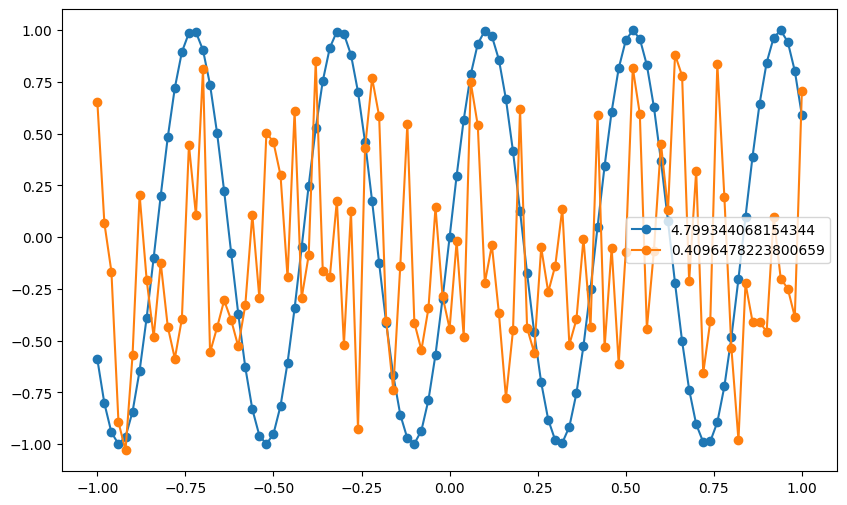

3 65.30442200601101


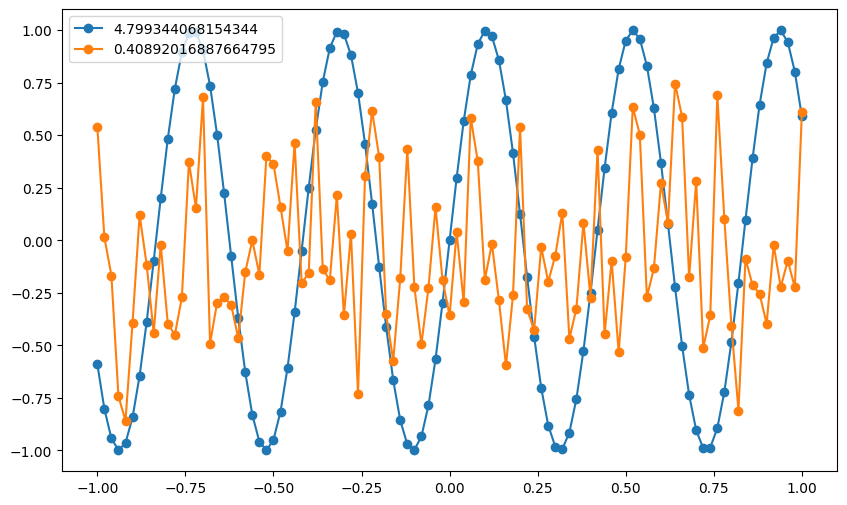

7 30.282313603907824


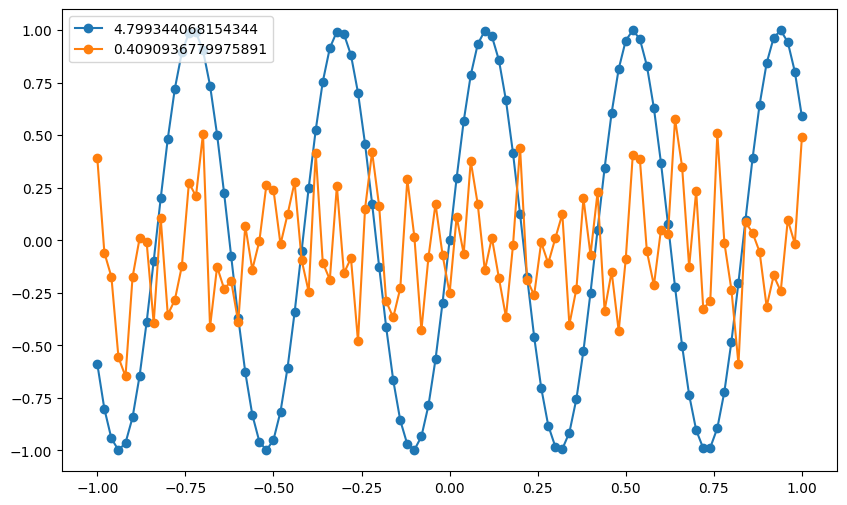

15 15.956317201605998


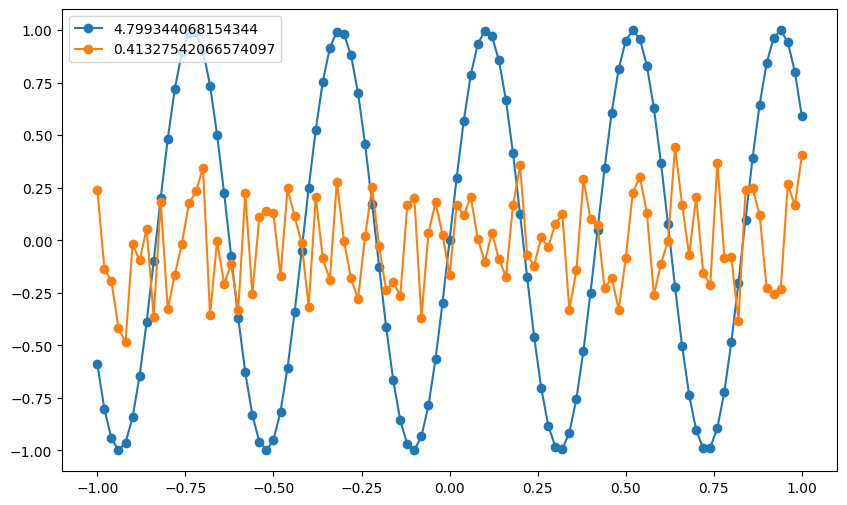

20 13.857291995940614


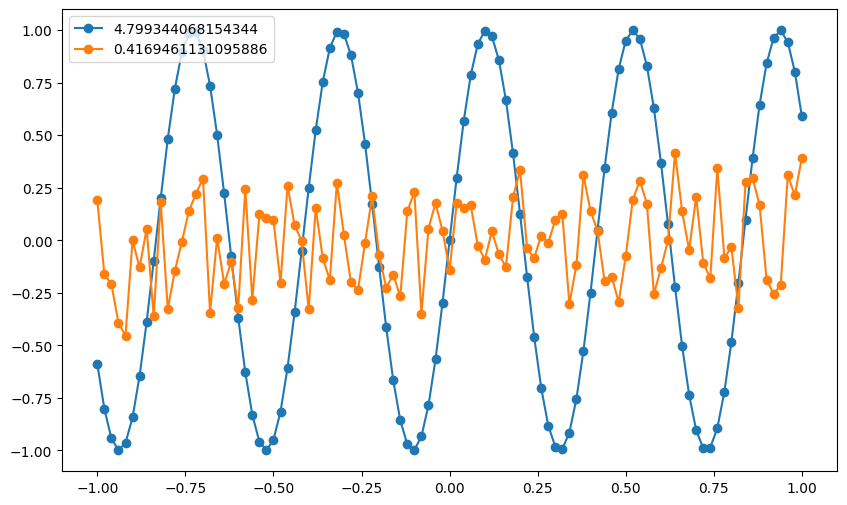

31 11.012274374619665


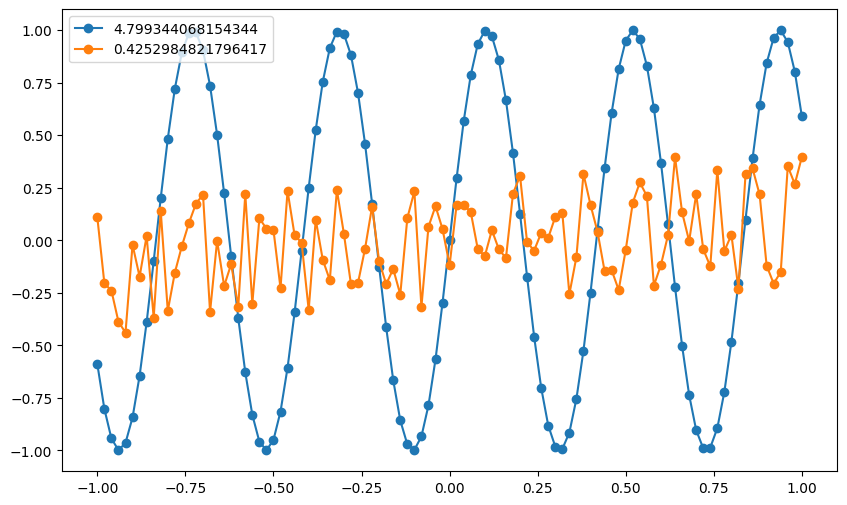

40 9.055065762216515


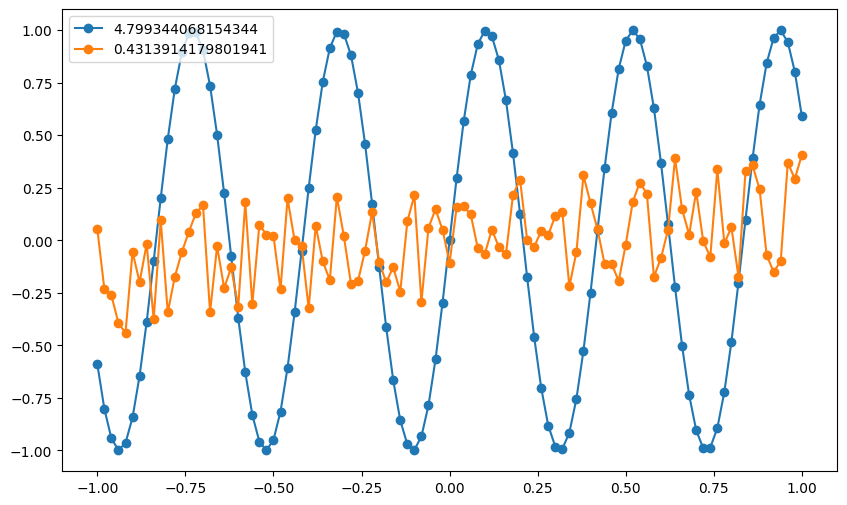

60 5.585921541198825


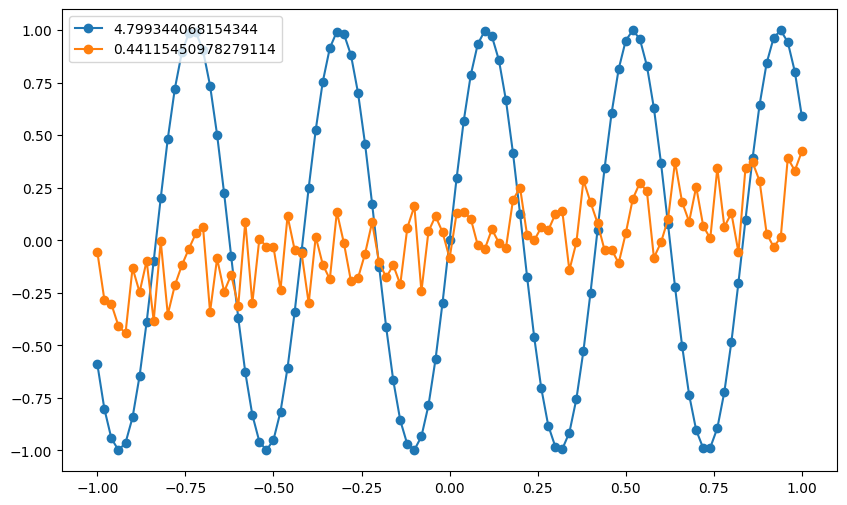

63 5.172961808501675


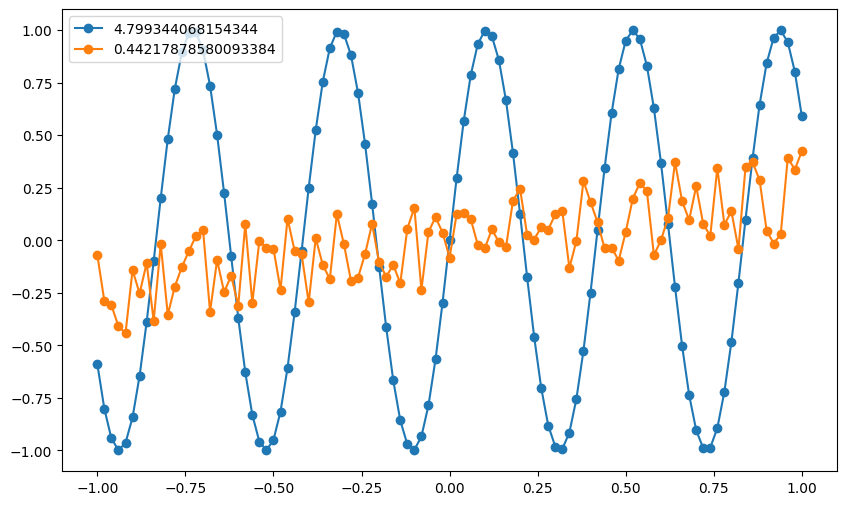

80 3.3061413463566005


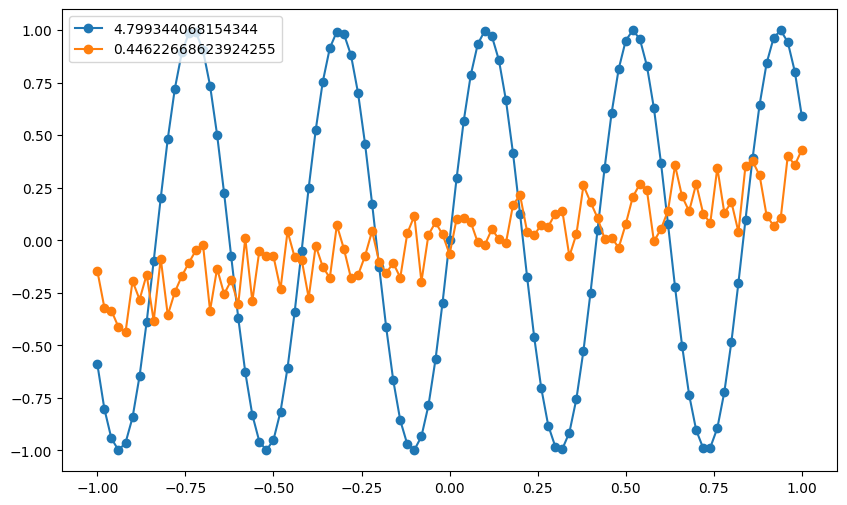

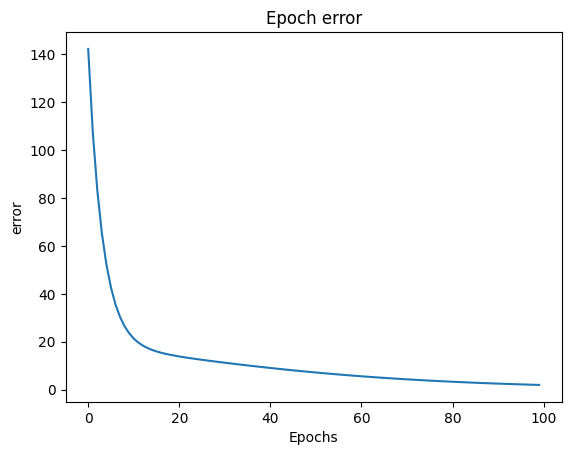

In [398]:
epochs = 100  # 10000

testCurve = gen_sinus_curve(discretization)

errorsEpochs = train(encoderModel, decoderModel, data_train, testCurve, epochs, True)

plt.plot(range(epochs), errorsEpochs)
plt.title("Epoch error")
plt.xlabel("Epochs")
plt.ylabel("error")
plt.show()


Affichez sur un graphe, G et sa reconstruction par l'autoencodeur

Calculez les distances entre l'entrée et la sortie

Vous venez de découvrir l'un des usages des autoencodeurs : La détection d'anomalies

Est-ce que la même architecture peut encoder des fonctions affine *et* des sinus?

- Que changer ?
- Implémentez !

Maintenant dans l'entrainement incluez des fonctions affines et des sinus. 

Changez $z$ vous n'avez plus la contrainte dimension = 1.

Entrainez!

Avec cette architecture je veux maintenant que vous puissiez me dire si c'est un sinus ou une fonction affine :
 - On fait de la classification avec ce réseau